# SGD and variations

Here you'll find a numpy implementation of **SGD and extensions (as Momentum, AdaGrad, RMSProp, Adam)** in a syntetic dataset and iris dataset made only for leaning purposes.

## Dependencies

In [2]:
%matplotlib inline
%matplotlib agg

import math

import numpy as np
np.random.seed(0)  # make this notebook reproducible
import pandas as pd
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

## Getting data

### Loading iris dataset

In [219]:
# load iris
iris = load_iris()
# np.c_ is the numpy concatenate function
# which is used to concat iris['data'] and iris['target'] arrays 
iris_data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                         columns= iris['feature_names'] + ['target'])

In [220]:
print(len(iris_data))

150


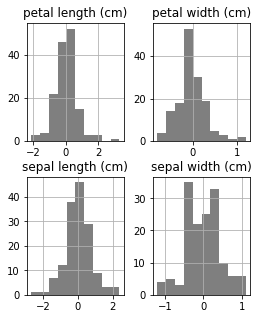

In [221]:
iris_data.drop(['target'], axis=1).diff().hist(color='k', alpha=0.5, bins=10, figsize=(4, 5))
plt.show()

### Generating syntethic dataset

In [222]:
SYNT_TRAIN_SIZE = 50

def get_random_error(size, mu=0, std_dev=0.8):
    return np.random.normal(mu, std_dev, size)

# generate the function: 7 * X + 15, it can be a more complicated function, but let's keep it simple for now
synt_x = np.random.rand(SYNT_TRAIN_SIZE)
synt_y = np.reshape(7 * synt_x + 15 + get_random_error(SYNT_TRAIN_SIZE), (SYNT_TRAIN_SIZE, 1))

synt_x = np.reshape(synt_x, (SYNT_TRAIN_SIZE, 1))

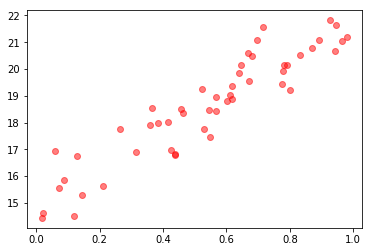

In [223]:
plt.plot(synt_x, synt_y, 'ro', alpha=0.5)

## Implementing a feed forward neural network

In [298]:
class NeuralNetwork(object):    
    def __init__(self, layers, input_size, act_name=None):
        self.input_size = input_size
        self.layers = layers
        
        self.act_name = act_name
        self.activation = self.get_act(act_name)
        
        self.weights, self.biases = self.define_params(self.input_size, self.layers)

        
    def get_act(self, act_name):
        def _sigmoid(x):
            return 1 / (1 + np.exp(-x))
        def _relu(x):
            return x * (x > 0)
        if act_name is None:
            return None
        elif act_name == 'sigmoid':
            return _sigmoid
        elif act_name == 'relu':
            return _relu
        else:
            raise ValueError('Activation function is not valid: %s' % act_name)
        
        
    def define_params(self, input_size, layers):
        weights = []
        biases = []
        for i, (in_dim, out_dim) in enumerate(zip([input_size] + layers, layers)):
            weights.append(np.random.randn(in_dim, out_dim))
            biases.append(np.random.randn(out_dim))

        return weights, biases


    def update_params(self, gradients, learning_rate=0.1):
        assert len(gradients) == len(self.weights)
        assert len(gradients) == len(self.biases)
        
        for i, grad in enumerate(gradients):
            # assert grad['weights'].shape == self.weights[i].shape
            self.weights[i] -= learning_rate * grad['weights']
            # assert grad['biases'].shape == self.biases[i].shape
            self.biases[i] -= learning_rate * grad['biases']
    
    def run_batch(self, batch):
        output = batch
        for w, b in zip(self.weights, self.biases):
            output = np.dot(output, w) + b
            if self.activation:
                output = self.activation(output)
        return output

### Implementing SGD trainer

In [334]:
class Trainer(object):
    def __init__(self, model, learning_rate = 0.1, loss_name='l2',
                 print_mod=10, verbose=True):
        self.model = model
        self.loss_name = loss_name
        self.learning_rate = learning_rate
        self.loss = self.get_loss(self.loss_name)
        
        self.train_step = 0
        self.verbose = verbose
        self.print_mod = print_mod
        self.losses = []
    
    
    def get_loss(self, loss_name):
        def _l2(pred_y, real_y):
            input_size = pred_y.shape[0]
            return (1/2.0 * input_size) * np.sum(np.power(pred_y - real_y, 2))
            
        if loss_name == 'l2':
            return _l2
        else:
            raise ValueError('Invalid loss name: %s' % loss_name)


    def train(self, batch_x, batch_y):
        self.train_step += 1
        
        # run feed forward network
        pred_y = self.model.run_batch(batch_x)
        # save loss
        self.losses.append(self.loss(pred_y, batch_y))
        # get gradients
        grads = self.generate_gradients(pred_y, batch_y, batch_x)
        # update parameters
        self.model.update_params(grads, self.learning_rate)

        if self.verbose and (self.train_step - 1) % self.print_mod == 0:
            print('Loss: %.4f for step %d' % (self.losses[-1], self.train_step))
    
    def plot_losses(self):
        x = [i for i in range(self.train_step)]
        plt.title('Loss: %.4f for step %d' % (self.losses[-1], self.train_step))
        plt.plot(x, self.losses)
        
        
    def generate_gradients(self, pred_y, real_y, data_x):
        def _l2(pred_y, real_y, data_x):
            '''For now just works for 1 hidden layer.'''
            def _sigmoid(x):
                return 1 / (1 + np.exp(-x))
            def _dev_sigmoid(x):
                return _sigmoid(x) * (1 - _sigmoid(x))
            
            grad = []
            input_size = pred_y.shape[0]
            if self.model.activation is None:
                grad.append({
                    'weights': -1/input_size * np.sum((real_y - pred_y) * data_x),
                    'biases': -1/input_size * np.sum((real_y - pred_y))
                })
            elif self.model.act_name == 'sigmoid':
                # Wrong
                grad.append({
                    'weights': -1/input_size * np.sum((real_y - pred_y) * _dev_sigmoid(data_x) * data_x),
                    'biases': -1/input_size * np.sum((real_y - pred_y) * _dev_sigmoid(data_x))
                })
            elif self.model.act_name == 'relu':
                zero_indexes = np.where(pred_y == 0)[0]
                real_y = np.delete(real_y, zero_indexes, axis=0)
                pred_y = np.delete(pred_y, zero_indexes, axis=0)
                data_x = np.delete(data_x, zero_indexes, axis=0)
                grad_weight = -1/input_size * np.sum((real_y - pred_y) * _dev_sigmoid(data_x) * data_x)
                grad_bias = -1/input_size * np.sum((real_y - pred_y))
                grad.append({
                    'weights': grad_weight,
                    'biases': grad_bias
                })
            return grad

            
        if self.loss_name == 'l2':
            return _l2(pred_y, real_y, data_x)

In [335]:
nn = NeuralNetwork([1], 1)
t = Trainer(nn)

Loss: 163468.8790 for step 1
Loss: 84988.9021 for step 11
Loss: 75382.7490 for step 21
Loss: 70721.8026 for step 31
Loss: 66913.9555 for step 41
Loss: 63629.9804 for step 51
Loss: 60786.2987 for step 61
Loss: 58323.1542 for step 71
Loss: 56189.5786 for step 81
Loss: 54341.4725 for step 91


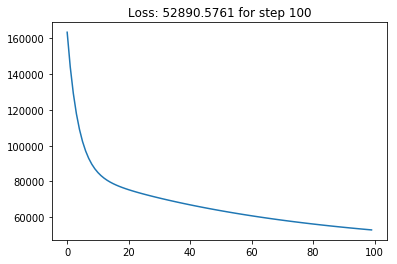

In [324]:
for i in range(100):
    t.train(synt_x, synt_y)

t.plot_losses()

Learned parameters:
weights: [array([[14.28076827]])]
biases: [array([0.42470735])]
Input function: 7 * X + 15


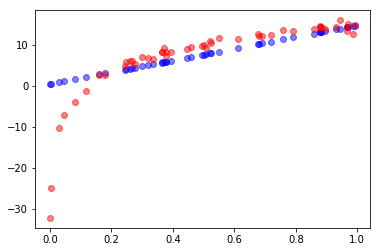

In [325]:
print('Learned parameters:')
print('weights:', nn.weights)
print('biases:', nn.biases)
print('Input function: 7 * X + 15')
plt.plot(synt_x, nn.run_batch(synt_x), 'bo', synt_x, synt_y, 'ro', alpha=0.5)


### What if the data is not linear?

In [326]:
def get_random_error(size, mu=0, std_dev=0.8):
    return np.random.normal(mu, std_dev, size)

# generate the function: 7 * X + 15, it can be a more complicated function, but let's keep it simple for now
synt_x = np.random.rand(SYNT_TRAIN_SIZE)
synt_y = np.reshape(7 * np.log(synt_x) + 15 + get_random_error(SYNT_TRAIN_SIZE), (SYNT_TRAIN_SIZE, 1))

synt_x = np.reshape(synt_x, (SYNT_TRAIN_SIZE, 1))

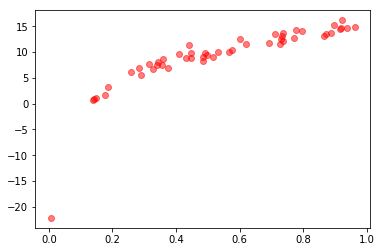

In [327]:
plt.plot(synt_x, synt_y, 'ro', alpha=0.5)

In [328]:
nn = NeuralNetwork([1], 1)
t = Trainer(nn)

Loss: 201287.0654 for step 1
Loss: 41981.5931 for step 11
Loss: 30870.3244 for step 21
Loss: 28815.0922 for step 31
Loss: 27434.6321 for step 41
Loss: 26212.6828 for step 51
Loss: 25107.1309 for step 61
Loss: 24105.4168 for step 71
Loss: 23197.6989 for step 81
Loss: 22375.1517 for step 91


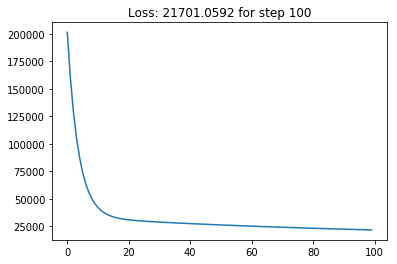

In [329]:
for i in range(100):
    t.train(synt_x, synt_y)

t.plot_losses()

Learned parameters:
weights: [array([[9.82538981]])]
biases: [array([4.21399388])]
Input function: 7 * log(X) + 15


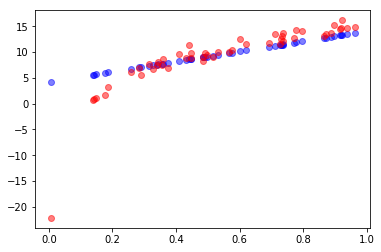

In [330]:
print('Learned parameters:')
print('weights:', nn.weights)
print('biases:', nn.biases)
print('Input function: 7 * log(X) + 15')
plt.plot(synt_x, nn.run_batch(synt_x), 'bo', synt_x, synt_y, 'ro', alpha=0.5)


In [337]:
nn = NeuralNetwork([1], 1, act_name='relu')
t = Trainer(nn)

Loss: 135947.2612 for step 1
Loss: 50500.5584 for step 11
Loss: 40943.6230 for step 21
Loss: 39376.6174 for step 31
Loss: 38667.7227 for step 41
Loss: 38064.0890 for step 51
Loss: 37484.8672 for step 61
Loss: 36920.7624 for step 71
Loss: 36370.3430 for step 81
Loss: 35833.1222 for step 91


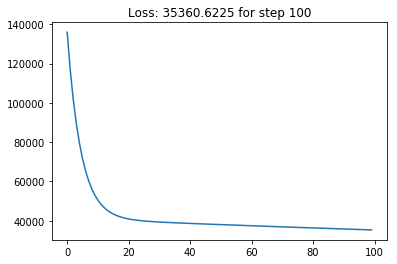

In [338]:
for i in range(100):
    t.train(synt_x, synt_y)

t.plot_losses()

Learned parameters:
weights: [array([[3.12774166]])]
biases: [array([7.70309994])]
Input function: 7 * log(X) + 15


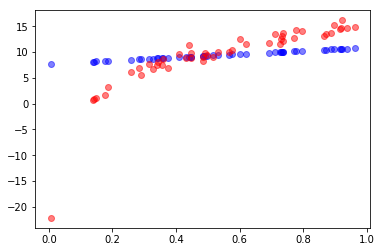

In [339]:
print('Learned parameters:')
print('weights:', nn.weights)
print('biases:', nn.biases)
print('Input function: 7 * log(X) + 15')
plt.plot(synt_x, nn.run_batch(synt_x), 'bo', synt_x, synt_y, 'ro', alpha=0.5)
